# Predicting Packet Loss

### Contents:
1. Dataset
2. Data Cleaning
3. Data Visualization
4. Real-Time Queries
5. Adaptive Element
6. Outcome Accuracy
7. Security Measures
8. Product Health Monitoring
9. Dashboard
10. Analytics
11. Data Methods
    * K Means Clustering
    * Logistic Regression

<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>

In [1]:
# import ML libraries
import datetime as dt
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import dash
import dash_table
import dash_core_components as dcc
import dash_html_components as html

import cufflinks as cf
from plotly import graph_objs as go
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


%matplotlib inline

### 1. Dataset
* Import switch_data.csv from data directory

In [2]:
# import raw dataset into dataframe
df = pd.read_csv("~/Documents/packet-drop-prediction/data/switch_data.csv")
df_copy = df.copy(deep=True)
df

timestamp  cpu_utilization_interrupt  cpu_utilization_total  \
0    6/9/2020 0:00:00                          8                     11   
1    6/9/2020 1:00:00                         12                     21   
2    6/9/2020 2:00:00                         52                     76   
3    6/9/2020 3:00:00                         29                     45   
4    6/9/2020 4:00:00                         12                     34   
5    6/9/2020 5:00:00                          9                     36   
6    6/9/2020 6:00:00                         75                     80   
7    6/9/2020 7:00:00                         70                     85   
8    6/9/2020 8:00:00                         96                     99   
9    6/9/2020 9:00:00                         80                     87   
10  6/9/2020 10:00:00                         81                     91   
11  6/9/2020 11:00:00                         90                     92   
12  6/9/2020 12:00:00                          2                     13   
13  6/9/2020 13:00:00                         12                     15   
14  6/9/2020 14:00:00                         10                     12   
15  6/9/2020 15:00:00                         37                     50   
16  6/9/2020 16:00:00                         50                     59   
17  6/9/2020 17:00:00                         32                     54   
18  6/9/2020 18:00:00                         43                     52   
19  6/9/2020 19:00:00                          9                     13   
20  6/9/2020 20:00:00                          1                     15   
21  6/9/2020 21:00:00                          2                     17   
22  6/9/2020 22:00:00                         26                     34   
23  6/9/2020 23:00:00                         11                     21   

    dropped_packets  packet_drop_rate top_system_process  dropped_packets_tcp  \
0                 1              0.10           IP Input                    0   
1                 2              0.19           IP Input                    0   
2                45              8.79          ARP Input                    0   
3                 1              3.14           IP Input                    0   
4                 2              0.31           IP Input                    0   
5                 4              0.34           IP Input                    0   
6                78             15.10          ARP Input                    0   
7               200             26.28          ARP Input                    0   
8               400             36.64          ARP Input                    0   
9               344             29.09          ARP Input                    0   
10              343             25.36          ARP Input                    0   
11              500             60.96          ARP Input                    0   
12                9              0.77           IP Input                    0   
13                6              0.42           IP Input                    0   
14                3              0.23           IP Input                    0   
15               11              2.28           IP Input                    0   
16               26              5.84           IP Input                    0   
17               30              4.75           IP Input                    0   
18               23              3.43           IP Input                    0   
19                2              0.76           IP Input                    0   
20                3              1.48           IP Input                    0   
21                2              4.09           IP Input                    0   
22               14              2.65           IP Input                    0   
23                4              0.02           IP Input                    0   

    dropped_packets_udp  sw_forwarding  
0                     0              1  
1                     0     

### 2. Data Cleaning
* Identify data redundancy
* Identify columns with missing values
* Modify column data types

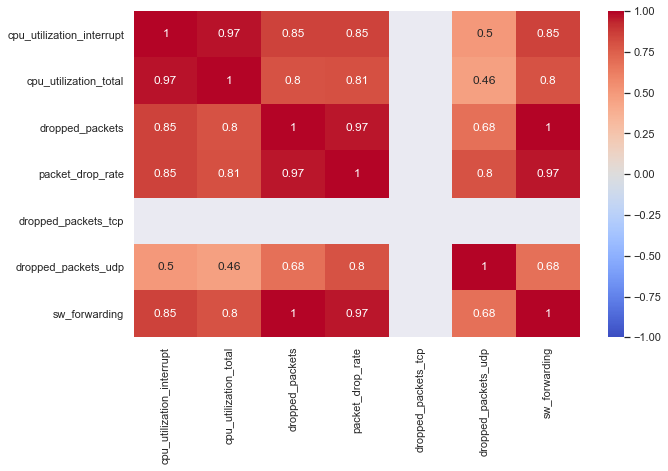

In [3]:
sns.set()

# identify data redundancy or missing values using a confusion matrix
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=True);

The following columns have a 1:1 (or extremely close) relationship:
* dropped_packets and sw_forwarding
* cpu_utilization_interrupt and cpu_utilization_total
* packet_drop_rate and dropped_packets

In order to remove redundant columns, we'll drop sw_forwarding, cpu_utilization_total, dropped_packets. The dropped_packets_tcp column contains all zero values, so it will be removed too.

In [4]:
# remove columns with data redundancy or missing values
df = df.drop('sw_forwarding', 1)
df = df.drop('cpu_utilization_total', 1)
df = df.drop('dropped_packets', 1)
df = df.drop('dropped_packets_tcp', 1)

In [5]:
# confirm drop was successful
print("columns names:")
for col in df.columns: 
    print(col) 

columns names:
timestamp
cpu_utilization_interrupt
packet_drop_rate
top_system_process
dropped_packets_udp


In [6]:
# modify top_system_process column
df = df.replace({'ARP Input': 1, 'IP Input': 0})
df = df.rename(columns={"top_system_process": "arp_top_system_process"})

# confirm column name and datatype
df.dtypes

timestamp                     object
cpu_utilization_interrupt      int64
packet_drop_rate             float64
arp_top_system_process         int64
dropped_packets_udp            int64
dtype: object

### 3. Data Visualization
* Time series
* Box and whisker plot
* Scatter plot

#### Time Series

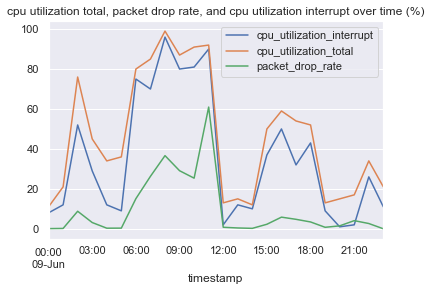

In [7]:
# display cpu utilization total, packet drop rate, and cpu utilization interrupt over time
series = pd.read_csv('~/Documents/packet-drop-prediction/data/switch_data.csv', usecols=['timestamp','packet_drop_rate','cpu_utilization_interrupt', 'cpu_utilization_total'], header=0, index_col=0, parse_dates=True)
series.plot(title='cpu utilization total, packet drop rate, and cpu utilization interrupt over time (%)')
plt.show()

#### Box and Whisker Plot

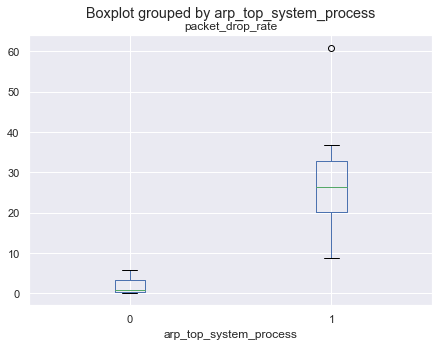

In [8]:
# display packet drop rate grouped by arp_top_system_process
boxplot = df.boxplot(column='packet_drop_rate', by='arp_top_system_process', figsize=(7,5))

#### Scatter Plot

Text(0, 0.5, 'packet_drop_rate')

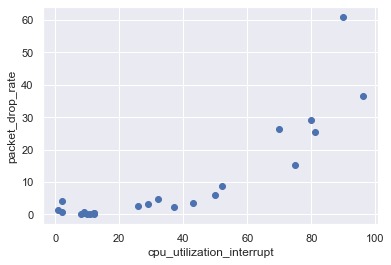

In [9]:
# display cpu utilization interrupt vs packet drop rate
plt.scatter(df.cpu_utilization_interrupt,df['packet_drop_rate'])
plt.xlabel('cpu_utilization_interrupt')
plt.ylabel('packet_drop_rate')

### Data Methods
* K Means Clustering
* Logistical Regression

#### K Means Clustering

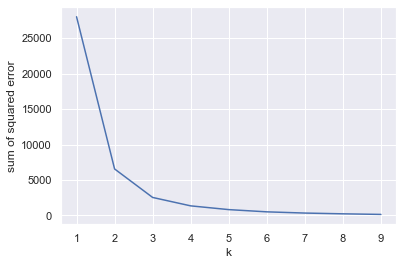

In [10]:
# determine optimal number of clusters
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df[['cpu_utilization_interrupt','packet_drop_rate']])
    sse.append(km.inertia_)
    
# display elbow curve
plt.xlabel('k')
plt.ylabel('sum of squared error')
plt.plot(k_rng,sse)

In [11]:
# generate clusters using optimal value for k
km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(df[['cpu_utilization_interrupt','packet_drop_rate']])
y_predicted

array([0, 0, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0,
       2, 0], dtype=int32)

In [12]:
# add cluster column to dataframe
df['cluster'] = y_predicted

# confirm add was successful
print("column names:")
for col in df.columns: 
    print(col) 

column names:
timestamp
cpu_utilization_interrupt
packet_drop_rate
arp_top_system_process
dropped_packets_udp
cluster


In [13]:
# identify centroid coordinates
km.cluster_centers_

array([[ 8.        ,  0.79181818],
       [82.        , 32.23833333],
       [38.42857143,  4.41142857]])

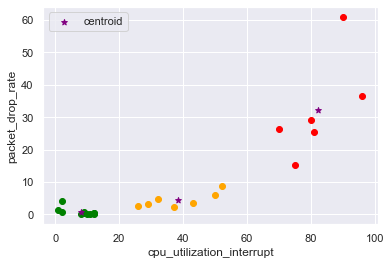

In [14]:
df1 = df[df.cluster==0]
df2 = df[df.cluster==1]
df3 = df[df.cluster==2]

# display clustered cpu utilization interrupt by packet drop rate
plt.scatter(df1.cpu_utilization_interrupt,df1['packet_drop_rate'],color='green')
plt.scatter(df2.cpu_utilization_interrupt,df2['packet_drop_rate'],color='red')
plt.scatter(df3.cpu_utilization_interrupt,df3['packet_drop_rate'],color='orange')

# display centroids
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='purple',marker='*',label='centroid')
plt.xlabel('cpu_utilization_interrupt')
plt.ylabel('packet_drop_rate')
plt.legend()

There are three distinct clusters: 
* low interrupt and low packet drop rate
* moderate interrupt and low-moderate packet drop rate
* high interrupt and moderate-high packet drop rate

#### Logistic Regression

In [15]:
# remove cluster column
df = df.drop('cluster', 1)

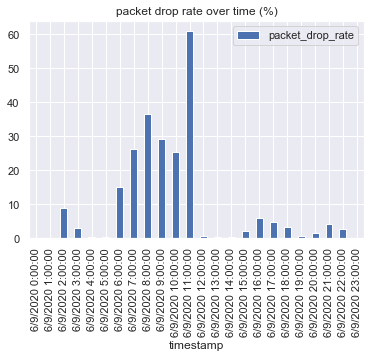

In [16]:
# display packet drop rate over time
df.plot(kind='bar', x='timestamp', y='packet_drop_rate', title='packet drop rate over time (%)')
plt.show()

In [17]:
# identify timestamp column datatype
df.dtypes

timestamp                     object
cpu_utilization_interrupt      int64
packet_drop_rate             float64
arp_top_system_process         int64
dropped_packets_udp            int64
dtype: object

In [18]:
# convert object to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
# , format='%Y-%m-%d %H:%M:%S'

# convert datetime to hour
df['timestamp'] = df['timestamp'].dt.hour

# confirm changes
df.head()

timestamp  cpu_utilization_interrupt  packet_drop_rate  \
0          0                          8              0.10   
1          1                         12              0.19   
2          2                         52              8.79   
3          3                         29              3.14   
4          4                         12              0.31   

   arp_top_system_process  dropped_packets_udp  
0                       0                    0  
1                       0                    0  
2                       1                    1  
3                       0                    0  
4                       0                    0

In [19]:
# add column for network degradation
df.insert(5, 'network_degraded', int)

# populate network_degraded column
df.loc[df['packet_drop_rate'] <= 5, 'network_degraded'] = 0
df.loc[df['packet_drop_rate'] > 5, 'network_degraded'] = 1

# enforce integer data type
df['network_degraded'] = df.network_degraded.astype(int)

# confirm network_degraded data type
df.dtypes

timestamp                      int64
cpu_utilization_interrupt      int64
packet_drop_rate             float64
arp_top_system_process         int64
dropped_packets_udp            int64
network_degraded               int64
dtype: object

In [20]:
# split out training and test sets
x_train, x_test, y_train, y_test = train_test_split(df[['timestamp']],df.network_degraded ,train_size=0.9)

In [21]:
# train the logistic regression model
model = LogisticRegression()
model = model.fit(x_train, y_train)

In [22]:
# display probabilities
model.predict_proba(x_test)

array([[0.73444799, 0.26555201],
       [0.69865164, 0.30134836],
       [0.7674078 , 0.2325922 ]])

### Outcome Accuracy

In [23]:
# display model score
print('Score: ', round(model.score(x_test,y_test)*100, 2),'%')

Score:  0.0 %


In [24]:
df.head()

timestamp  cpu_utilization_interrupt  packet_drop_rate  \
0          0                          8              0.10   
1          1                         12              0.19   
2          2                         52              8.79   
3          3                         29              3.14   
4          4                         12              0.31   

   arp_top_system_process  dropped_packets_udp  network_degraded  
0                       0                    0                 0  
1                       0                    0                 0  
2                       1                    1                 1  
3                       0                    0                 0  
4                       0                    0                 0

### Dashboard

In [25]:
from dash.dependencies import Input, Output
import dash_auth
import dash
import dash_table
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px

# set app username and password
CREDENTIALS = [['username', 'password']]
                                                                      
# load external stylesheets
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = dash.Dash(external_stylesheets=external_stylesheets)

# enforce authentication authentication
auth = dash_auth.BasicAuth(app, CREDENTIALS)

app.title = 'Packet Drop Prediction'

scatter = df.iplot(kind="scatter", theme="white",x="cpu_utilization_interrupt",y="packet_drop_rate", asFigure=True)

corr_matrix = df.corr().iplot(kind='heatmap', 
                              colorscale="Blues", 
                              title="Confusion Matrix", 
                              theme='white', 
                              asFigure=True)

app.layout = html.Div([
    
    # header
    html.Div([
        html.H1('Packet Drop Prediction'),
        html.Div('Predict network degradation based on packet drop rate and CPU utilization'),
        html.Div('Drag and select part of any graph to zoom in and inspect.  Double click graph to reset.')
    ], className = "row"),
    # graphs
    html.Div([
        html.Div([
            
            dcc.Graph(id='stacked_bar_chart', figure = scatter)
        ], className = "seven columns"),
        
        
        html.Div([
            
            dcc.Graph(id='correlation_matrix', figure = corr_matrix)
        ], className = "five columns")
    ], className="row"),
    
    # dummy row for formatting
    html.Div([
        html.H1('')
    ], className = 'row'),
    
    # data tables Row
    html.Div([
        # data Table
        html.Div([
           html.H6('Select check boxes on the left to explore and compare patient data.  Sort by any column by clicking on the arrows by the column name.'),
           dash_table.DataTable(
               id='Table',
               columns = [{'name': i, 'id': i} for i in df.columns],
               data=df.to_dict('records'),
               style_table={
                   'height': '300px',
               },
               style_header={
                   'backgroundColor': 'rgb(30, 30, 30)',
                   'fontWeight': 'bold'
               },
               style_cell={
                   'backgroundColor': 'rgb(50, 50, 50)',
                   'color': 'white'
               },
               sort_action='native',
               row_selectable='multiple',
               selected_rows=[0],
               fixed_rows={'headers': True, 'data': 0},
               style_cell_conditional=[
                   {'if': {'column_id': 'timestamp'},'width': '80px'},
                   {'if': {'column_id': 'cpu_utilization_interrupt'}, 'width': '80px'},
                   {'if': {'column_id': 'packet_drop_rate'}, 'width': '80px'},
                   {'if': {'column_id': 'arp_top_system_process'}, 'width': '80px'},
                   {'if': {'column_id': 'dropped_packets_tcp'}, 'width': '80px'},
                   {'if': {'column_id': 'network_degraded'}, 'width': '80px'},
               ],
               
           )
        ], className = 'six columns'),
        
        # linked subject bar chart
        html.Div([
            dcc.Graph(id='linked_histogram'), 
        ], className = 'six columns'),
        
    ], className = 'row')
    
    
])


@app.callback(
    Output('linked_histogram', 'figure'),
    [Input('Table', 'selected_rows')])

def update_graph(sr):
    
    d = df.iloc[sr]
    d = d.reset_index(drop=True)
    
    return d[['timestamp', 
              'cpu_utilization_interrupt',
              'packet_drop_rate', 
              'arp_top_system_process', 
              'dropped_packets_udp',
              'network_degraded'
             ]].iplot(kind='bar', # alt kind='area' or kind='scatter' or kind='bar'
                            barmode='grouped', 
                            theme='white', 
                            title = 'Click feature names on the right to add or remove to customize comparisons.',
                            fill=True , 
                            asFigure=True)



### Analytics

### Security Measures

In [ ]:
# sign into app using username and password
if __name__ == '__main__':
    app.run_server()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [22/Jun/2020 18:19:06] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [22/Jun/2020 18:19:07] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [22/Jun/2020 18:19:07] "GET /_dash-dependencies HTTP/1.1" 200 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/Users/quintin/opt/anaconda3/lib/python3.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/quintin/opt/anaconda3/lib/python3.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/quintin/opt/anaconda3/lib/python3.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/Users/quintin/opt/anaconda3/lib/python3.7/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/Users/quintin/opt/anaconda3/lib/python3.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/quintin/opt/anaconda3/lib/python3.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "/Users/quintin/

127.0.0.1 - - [22/Jun/2020 18:19:07] "POST /_dash-update-component HTTP/1.1" 500 -


     html.Div([
            
        dcc.Graph(
        id='life-exp-vs-gdp',
        figure={
            'data': [
                go.Scatter(
                    x=df[df['cpu_utilization_interrupt'] == i]['cpu_utilization_interrupt'],
                    y=df[df['cpu_utilization_interrupt'] == i]['packet_drop_rate'],
                    # text=df[df['continent'] == i]['country'],
                    mode='markers',
                    opacity=0.8,
                    marker={
                        'size': 15,
                        'line': {'width': 0.5, 'color': 'white'}
                    },
                    name=i
                ) for i in df.cpu_utilization_interrupt.unique()
            ],
            'layout': go.Layout(
                xaxis={'type': 'log', 'title': 'cpu_utilization_interrupt'},
                yaxis={'title': 'packet_drop_rate'},
                margin={'l': 40, 'b': 40, 't': 10, 'r': 10},
                legend={'x': 0, 'y': 1},
                hovermode='closest'
            )
        }
            )]),